In [1]:
import sys
import numpy
import random
import torch
import igraph
import utils
import matplotlib.pyplot as plt

In [2]:

class Params(object):
    batch_size = 64
    test_batch_size = 20
    epochs = 5
    lr = 0.01
    momentum = 0.5
    no_cuda = True
    seed = 1
    log_interval = 10

    def __init__(self):
        pass

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
args = Params()
device = torch.device("cpu")
mnistdata =  datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), 

    batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True)

In [32]:
import numpy
import torch

def layout(A):
    graph = igraph.Graph()
    graph.add_vertices(len(A))
    graph.add_edges(zip(*numpy.where(A==1)))
    return numpy.array(list(graph.layout_kamada_kawai()))

def checkAvailable(i,j,iMax,jMax):
    if i < 0 or j < 0:
        return False
    elif i > iMax or j > jMax:
        return False
    else:
        return True

# Function to generate a graph
def generateToGraph(dataRaw):
    data = dataRaw[0][0]
    nodes_features = []
    id =0
    edge_index = []
#     第几行，行的东西
    dict = []
    for i,line in enumerate(data):
        for j,item in enumerate(line):
            dict.append(item)
#     print(len(dict))
    for i,line in enumerate(data):
        iMax = len(data)-1
        for j,item in enumerate(line):
#             -0.4242129623889923
            jMax = len(line)-1
            nodes_features.append([item])
            if item.tolist() == -0.4242129623889923:
                id = id +1
                continue
            if checkAvailable(i+1,j,iMax,jMax) and dict[j+(i+1)*(jMax+1)].tolist() != -0.4242129623889923:
                edge_index.append([id,j+(i+1)*(jMax+1)])
            if checkAvailable(i-1,j,iMax,jMax) and dict[j+(i-1)*(jMax+1)].tolist() != -0.4242129623889923:
                edge_index.append([id,j+(i-1)*(jMax+1)])
            if checkAvailable(i+1,j+1,iMax,jMax) and dict[(j+1)+(i+1)*(jMax+1)].tolist() != -0.4242129623889923:
                edge_index.append([id,(j+1)+(i+1)*(jMax+1)])
            if checkAvailable(i+1,j-1,iMax,jMax) and dict[(j-1)+(i+1)*(jMax+1)].tolist() != -0.4242129623889923:
                edge_index.append([id,(j-1)+(i+1)*(jMax+1)])
            if checkAvailable(i-1,j+1,iMax,jMax) and dict[(j+1)+(i-1)*(jMax+1)].tolist() != -0.4242129623889923:
                edge_index.append([id,(j+1)+(i-1)*(jMax+1)])
            if checkAvailable(i-1,j-1,iMax,jMax) and dict[(j-1)+(i-1)*(jMax+1)].tolist() != -0.4242129623889923:
                edge_index.append([id,(j-1)+(i-1)*(jMax+1)])
            if checkAvailable(i,j+1,iMax,jMax) and dict[(j+1)+(i)*(jMax+1)].tolist() != -0.4242129623889923:
                edge_index.append([id,(j+1)+(i)*(jMax+1)])
            if checkAvailable(i,j-1,iMax,jMax) and dict[(j-1)+(i)*(jMax+1)].tolist() != -0.4242129623889923:
                edge_index.append([id,(j-1)+(i)*(jMax+1)])
            id = id +1
     
    A = numpy.zeros([784,784])
    for index in edge_index:
        A[index[0],index[1]] = 1
    # Add Self-Connections
    A = A + numpy.identity(len(A))
   

    # Build Data Structures
    D = A.sum(axis=1)
#     叉乘
    L = torch.FloatTensor(A/(numpy.outer(D,D)**.5+1e-9)) # laplacian

    return {
        'adjacency':torch.FloatTensor(A),
        'laplacian':L,
        'target':dataRaw[1],
        'layout':layout(A) 
    }


In [33]:

def vis_graph(g, ax):
    # Arange graph layout
    r = g['layout']
    r = r - r.min(axis=0)
    r = r / r.max(axis=0) * 2 - 1
    
    # Plot the graph 
    N = len(g['adjacency'])
    for i in numpy.arange(N):
        for j in numpy.arange(N):
            if g['adjacency'][i,j] > 0 and i != j: plt.plot([r[i,0], r[j,0]], [r[i,1], r[j,1]], color='gray', lw=0.5, ls='dotted')
    ax.plot(r[:,0],r[:,1],'o',color='black',ms=3)



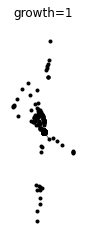

In [43]:
train_data = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))


# Plotting
plt.figure(figsize=(1, 3))
ax =plt.subplot( 1,1, 1)
g = generateToGraph(train_data[8])    
vis_graph(g, ax=ax)
plt.subplots_adjust(left=0,right=1,bottom=0,top=1)

plt.axis('off')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
ax.set_title('growth={}'.format( g['target']))

plt.show()
plt.close()